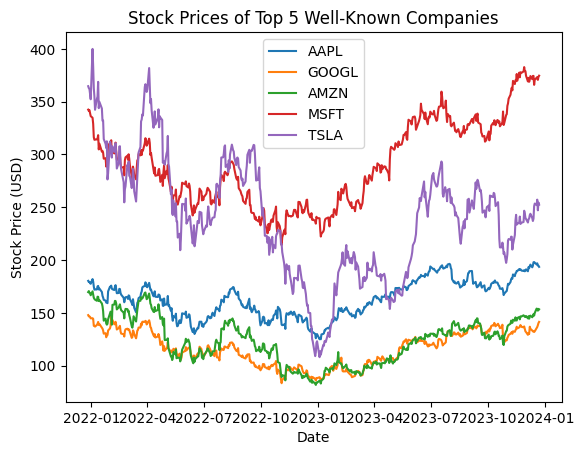

In [37]:
import pandas as pd
from pymongo import MongoClient
import matplotlib.pyplot as plt

# Connect to MongoDB (replace 'your_mongodb_uri' and 'your_database_name')
client = MongoClient('mongodb://127.0.0.1:27017/')
db = client['stockdata']
collection = db['stock']

# Fetch all documents from the collection
cursor = collection.find()

# Convert cursor to a list of dictionaries
data_list = list(cursor)

# Convert the list of dictionaries to a Pandas DataFrame
df = pd.DataFrame(data_list)



# Close the MongoDB connection
client.close()

# Define the top 5 well-known companies (you can adjust this list)
top_companies = ['AAPL', 'GOOGL', 'AMZN', 'MSFT', 'TSLA']

# Filter DataFrame for the top 5 companies
df_top5 = df[df['Symbol'].isin(top_companies)]

# Plot stock prices for each company
for company in top_companies:
    company_data = df_top5[df_top5['Symbol'] == company]
    plt.plot(company_data['Date'], company_data['Close'], label=company)

# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.title('Stock Prices of Top 5 Well-Known Companies')
plt.legend()
plt.show()
